In [1]:
import sys, os
from pathlib import Path
candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
PROJECT_ROOT = None
for c in candidates:
    if (c / "src").exists():
        PROJECT_ROOT = c
        break
if PROJECT_ROOT is None:
    raise RuntimeError("No se encontró la carpeta 'src' en niveles superiores.")
sys.path.insert(0, str(PROJECT_ROOT))
os.environ["PYTHONPATH"] = str(PROJECT_ROOT) + os.pathsep + os.environ.get("PYTHONPATH", "")
print("Project root:", PROJECT_ROOT)    

Project root: c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject


In [2]:
import numpy as np
import pandas as pd
import shap
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from src.utils import p, read_csv, ensure_dirs
from src.preprocessing import build_preprocessing_pipeline
from src.evaluation import (
    get_feature_names_from_preprocessor,
    importances_logreg, importances_tree, importances_permutation,
)
from src.visualization import (
    plot_shap_summary, plot_shap_waterfall, plot_importances_comparison
)

ensure_dirs()
DATA_RAW = p("data", "raw", "Titanic-Dataset.csv")
df = read_csv(DATA_RAW)
y = df[[c for c in df.columns if c.lower()=="survived"][0]].astype(int).values

# Split (igual que en 03 para comparabilidad)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y
)

# Preproc y transform
preproc = build_preprocessing_pipeline(df)
preproc.fit(X_train_df)
X_train = preproc.transform(X_train_df)
X_test  = preproc.transform(X_test_df)
feat_names = get_feature_names_from_preprocessor(preproc, sample_df=X_train_df)
len(feat_names), X_train.shape

(31, (712, 31))

In [3]:
RANDOM_STATE = 42

logreg = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=400, max_depth=None)
rf.fit(X_train, y_train)

xgb = XGBClassifier(
    random_state=RANDOM_STATE, n_estimators=400, learning_rate=0.1,
    max_depth=4, subsample=0.9, colsample_bytree=0.9, eval_metric="logloss", n_jobs=0
)
xgb.fit(X_train, y_train)

svm = SVC(probability=True, random_state=RANDOM_STATE, kernel="rbf", C=1.0)
svm.fit(X_train, y_train)


SVC(probability=True, random_state=42)

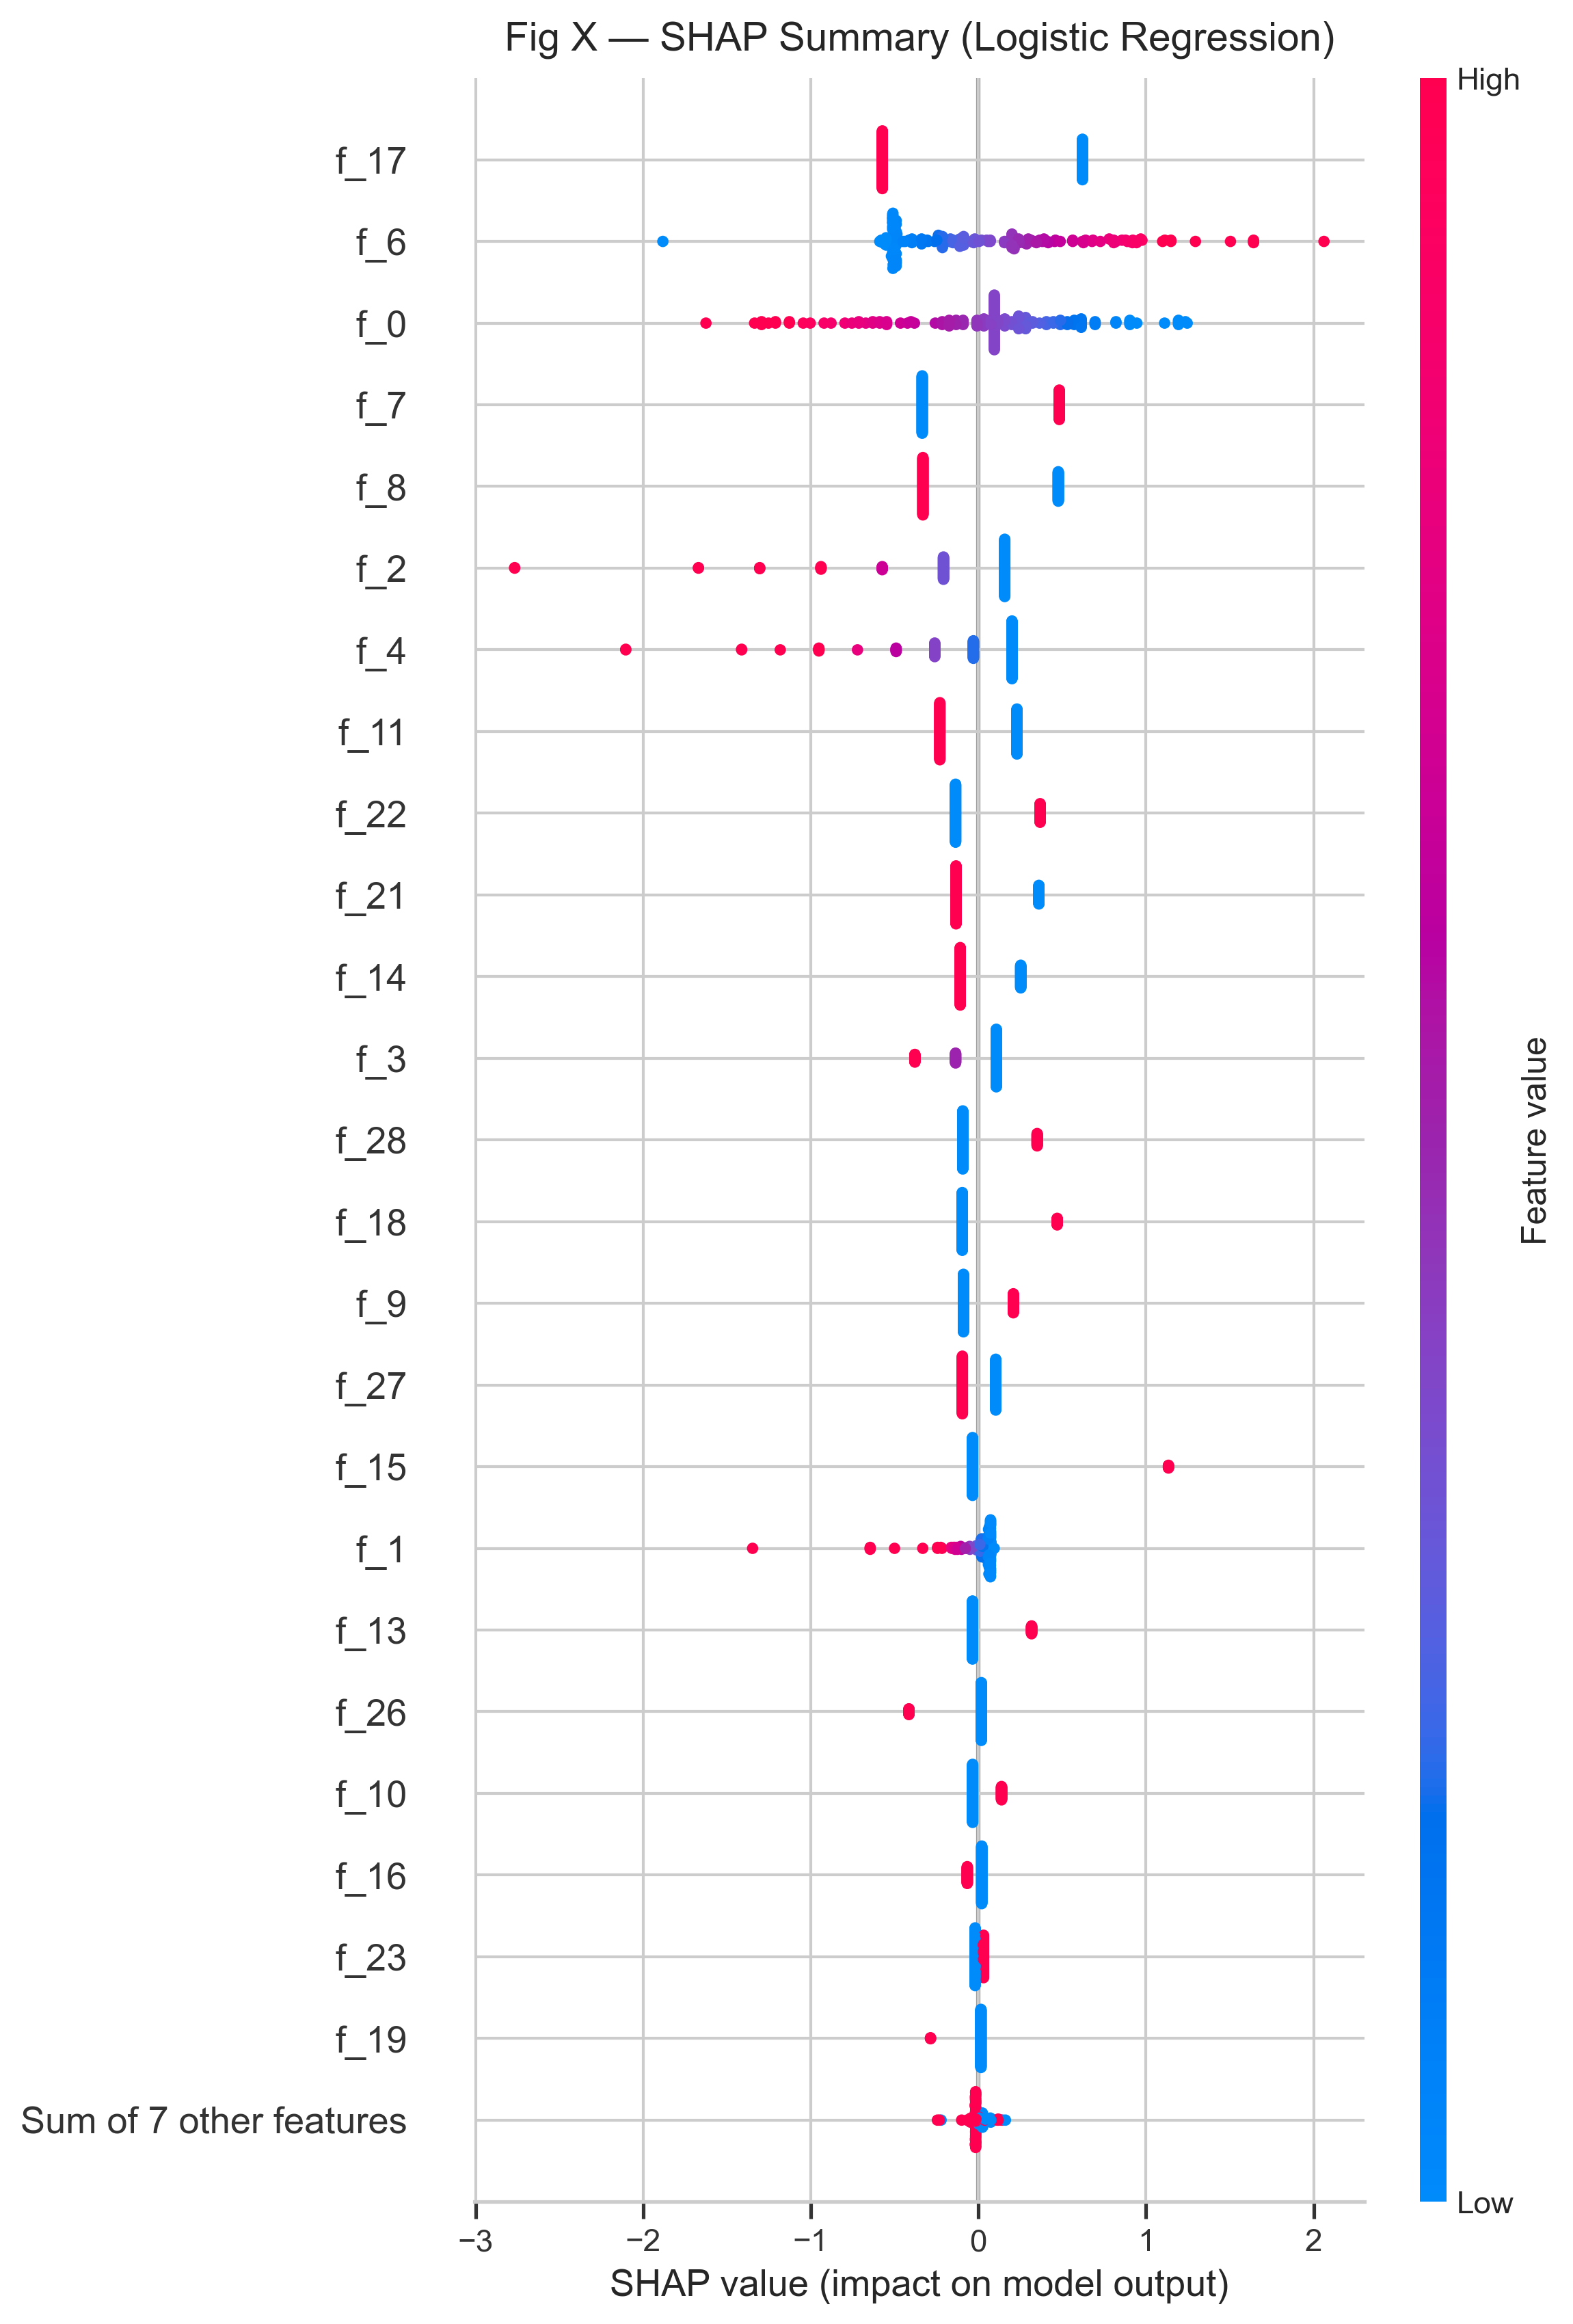

In [4]:
# Para modelos lineales
explainer = shap.LinearExplainer(logreg, X_train, feature_names=feat_names)
# Muestra SHAP en test (mismo espacio transformado)
shap_values_test = explainer(X_test)

figx_path = plot_shap_summary(
    shap_values_test, X_test,
    name="shap_summary_logreg",
    title="Fig X — SHAP Summary (Logistic Regression)",
    caption="Beeswarm de valores SHAP sobre el set de prueba para el modelo central (LogReg). Muestra qué features y rangos mueven más la predicción."
)
display(Image(filename=str(figx_path)))

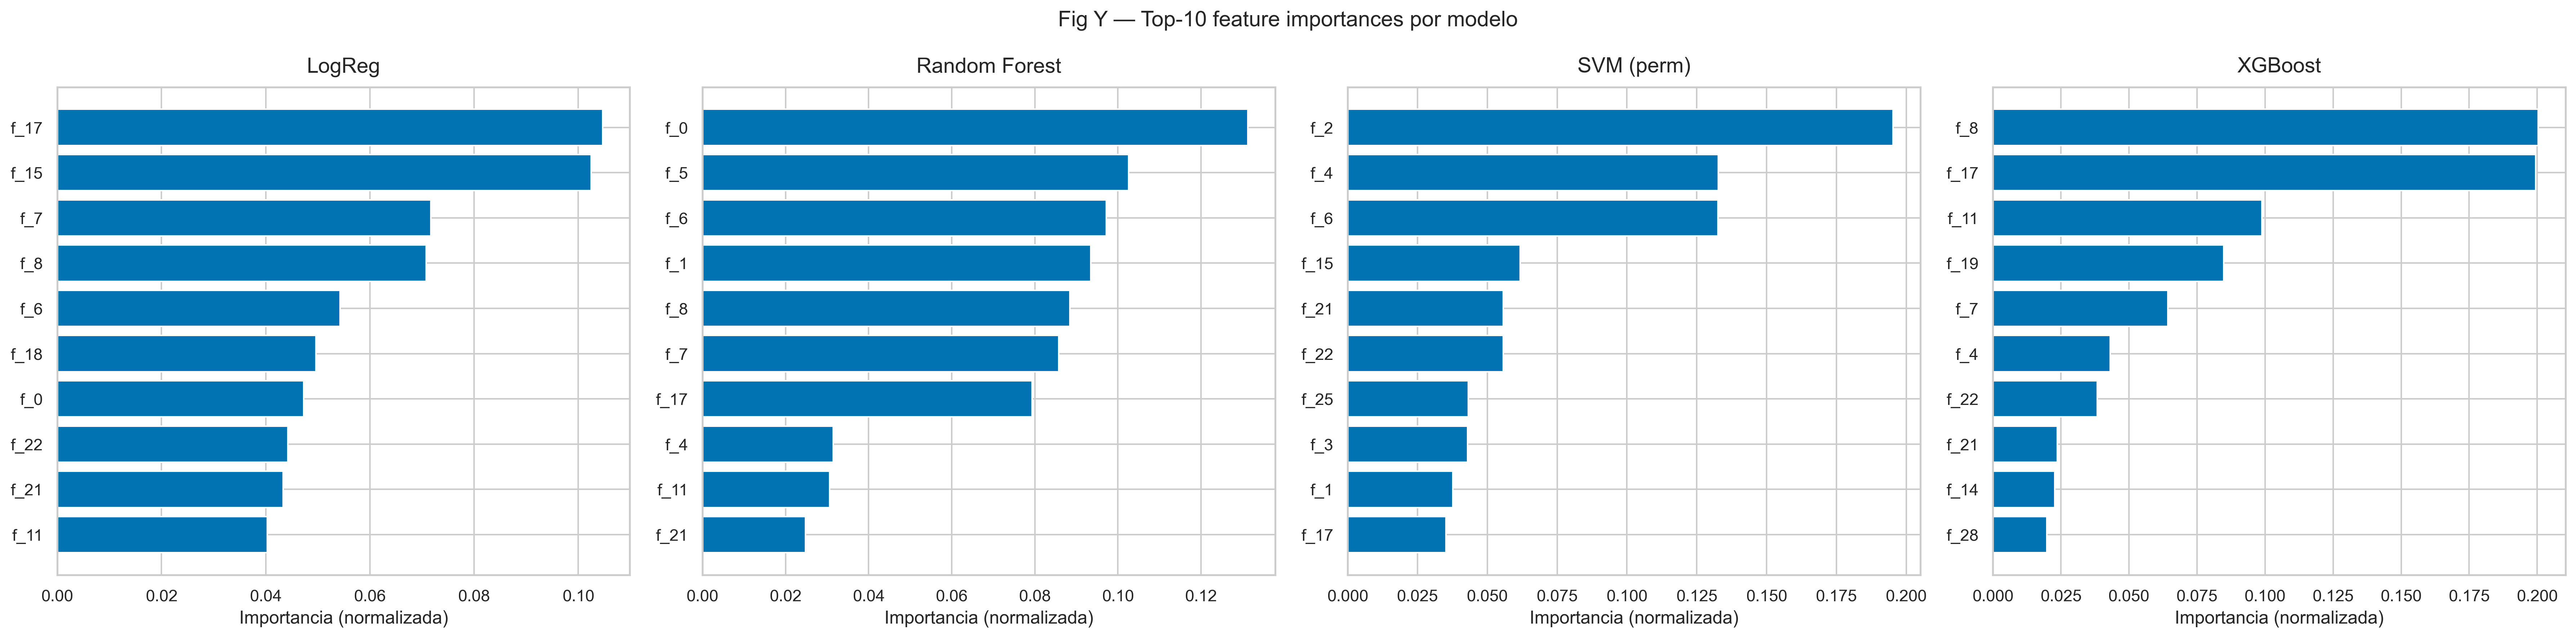

WindowsPath('C:/Users/luigu/OneDrive/Escritorio/Titanic_MLProject/results/tables/feature_importances_all_models_20250907_230337.csv')

In [5]:
# Importancias por modelo (normalizadas)
imp_lr  = importances_logreg(logreg, feat_names).assign(model="LogReg")
imp_rf  = importances_tree(rf, feat_names).assign(model="Random Forest")
imp_xgb = importances_tree(xgb, feat_names).assign(model="XGBoost")
# Para SVM RBF, usamos permutation importance en test
imp_svm = importances_permutation(svm, X_test, y_test, feat_names, n_repeats=15).assign(model="SVM (perm)")

imp_all = pd.concat([imp_lr, imp_rf, imp_xgb, imp_svm], ignore_index=True)

figy_path = plot_importances_comparison(
    imp_all, name="importances_top10_comparison",
    title="Fig Y — Top-10 feature importances por modelo",
    caption="Comparación de importancias normalizadas. LogReg usa |coef|; RF/XGB usan feature_importances_; SVM usa permutation importance en test.",
    top_k=10
)
display(Image(filename=str(figy_path)))

# Guardar tabla comparativa
from src.evaluation import save_metrics_table
tbl_imp_path = save_metrics_table(
    imp_all.sort_values(["model","importance"], ascending=[True, False]).round(6),
    name="feature_importances_all_models",
    description="Importancias normalizadas por modelo (LogReg coef, RF/XGB feature_importances_, SVM permutation importance)."
)
tbl_imp_path

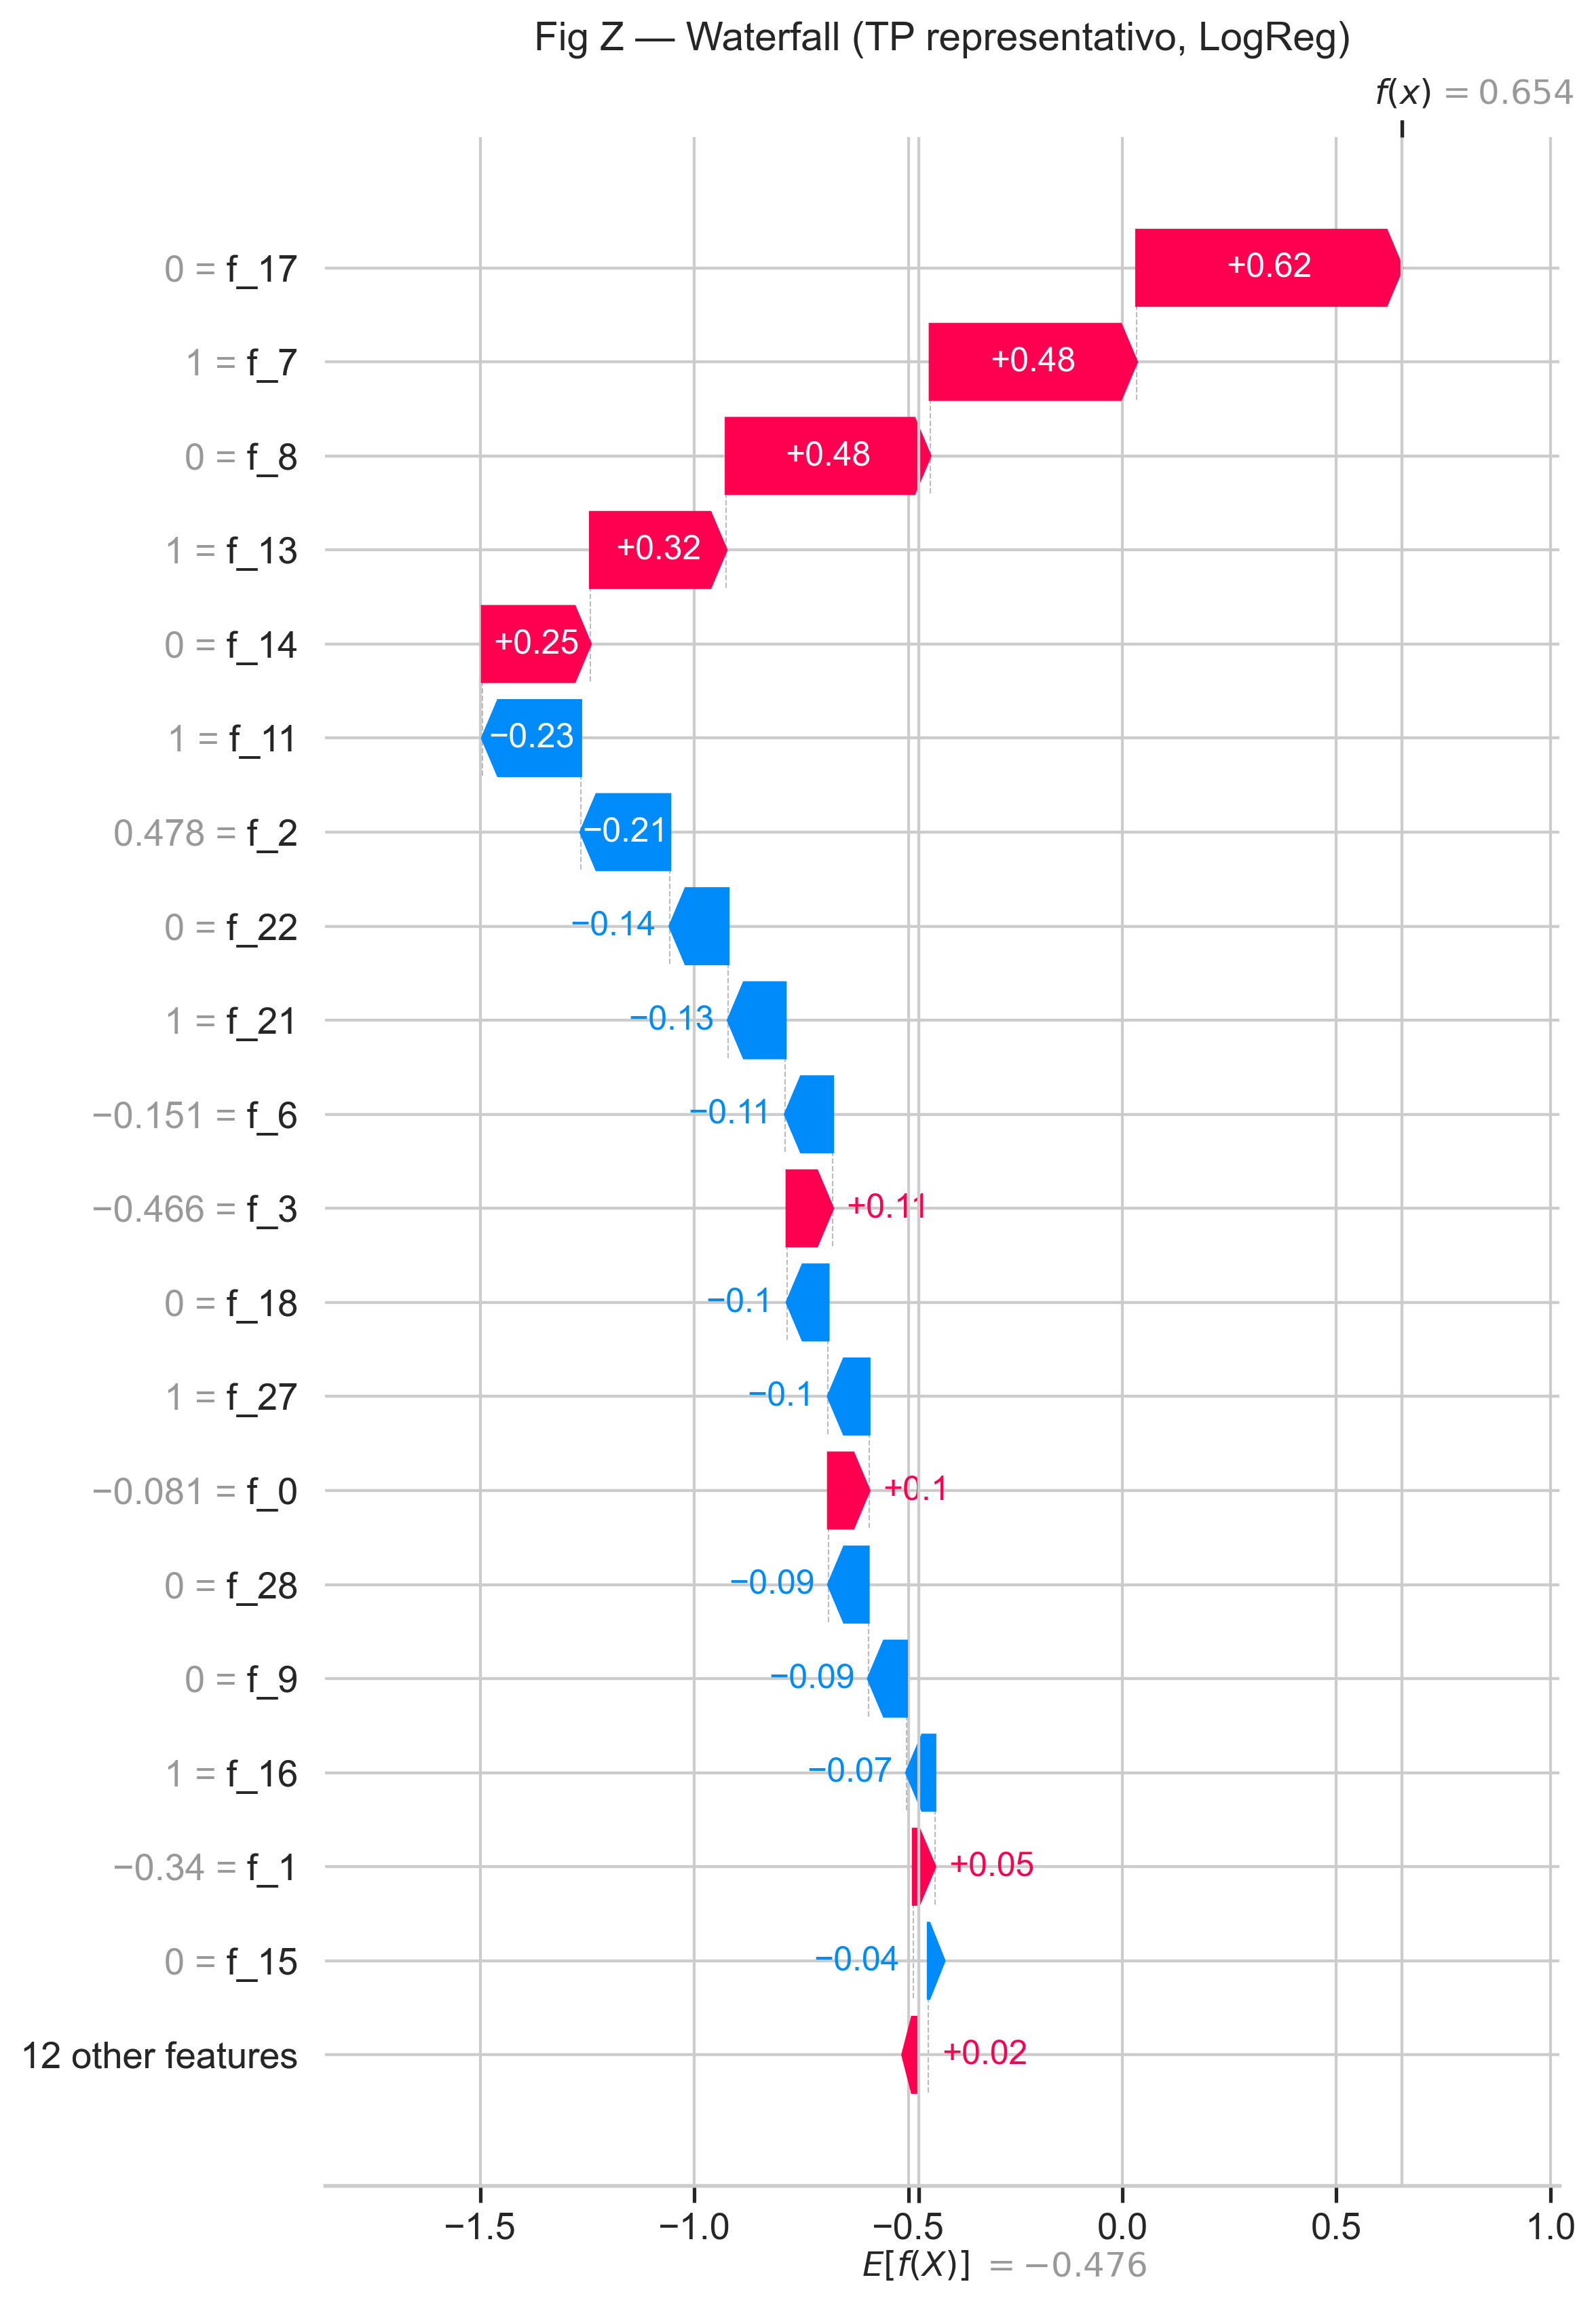

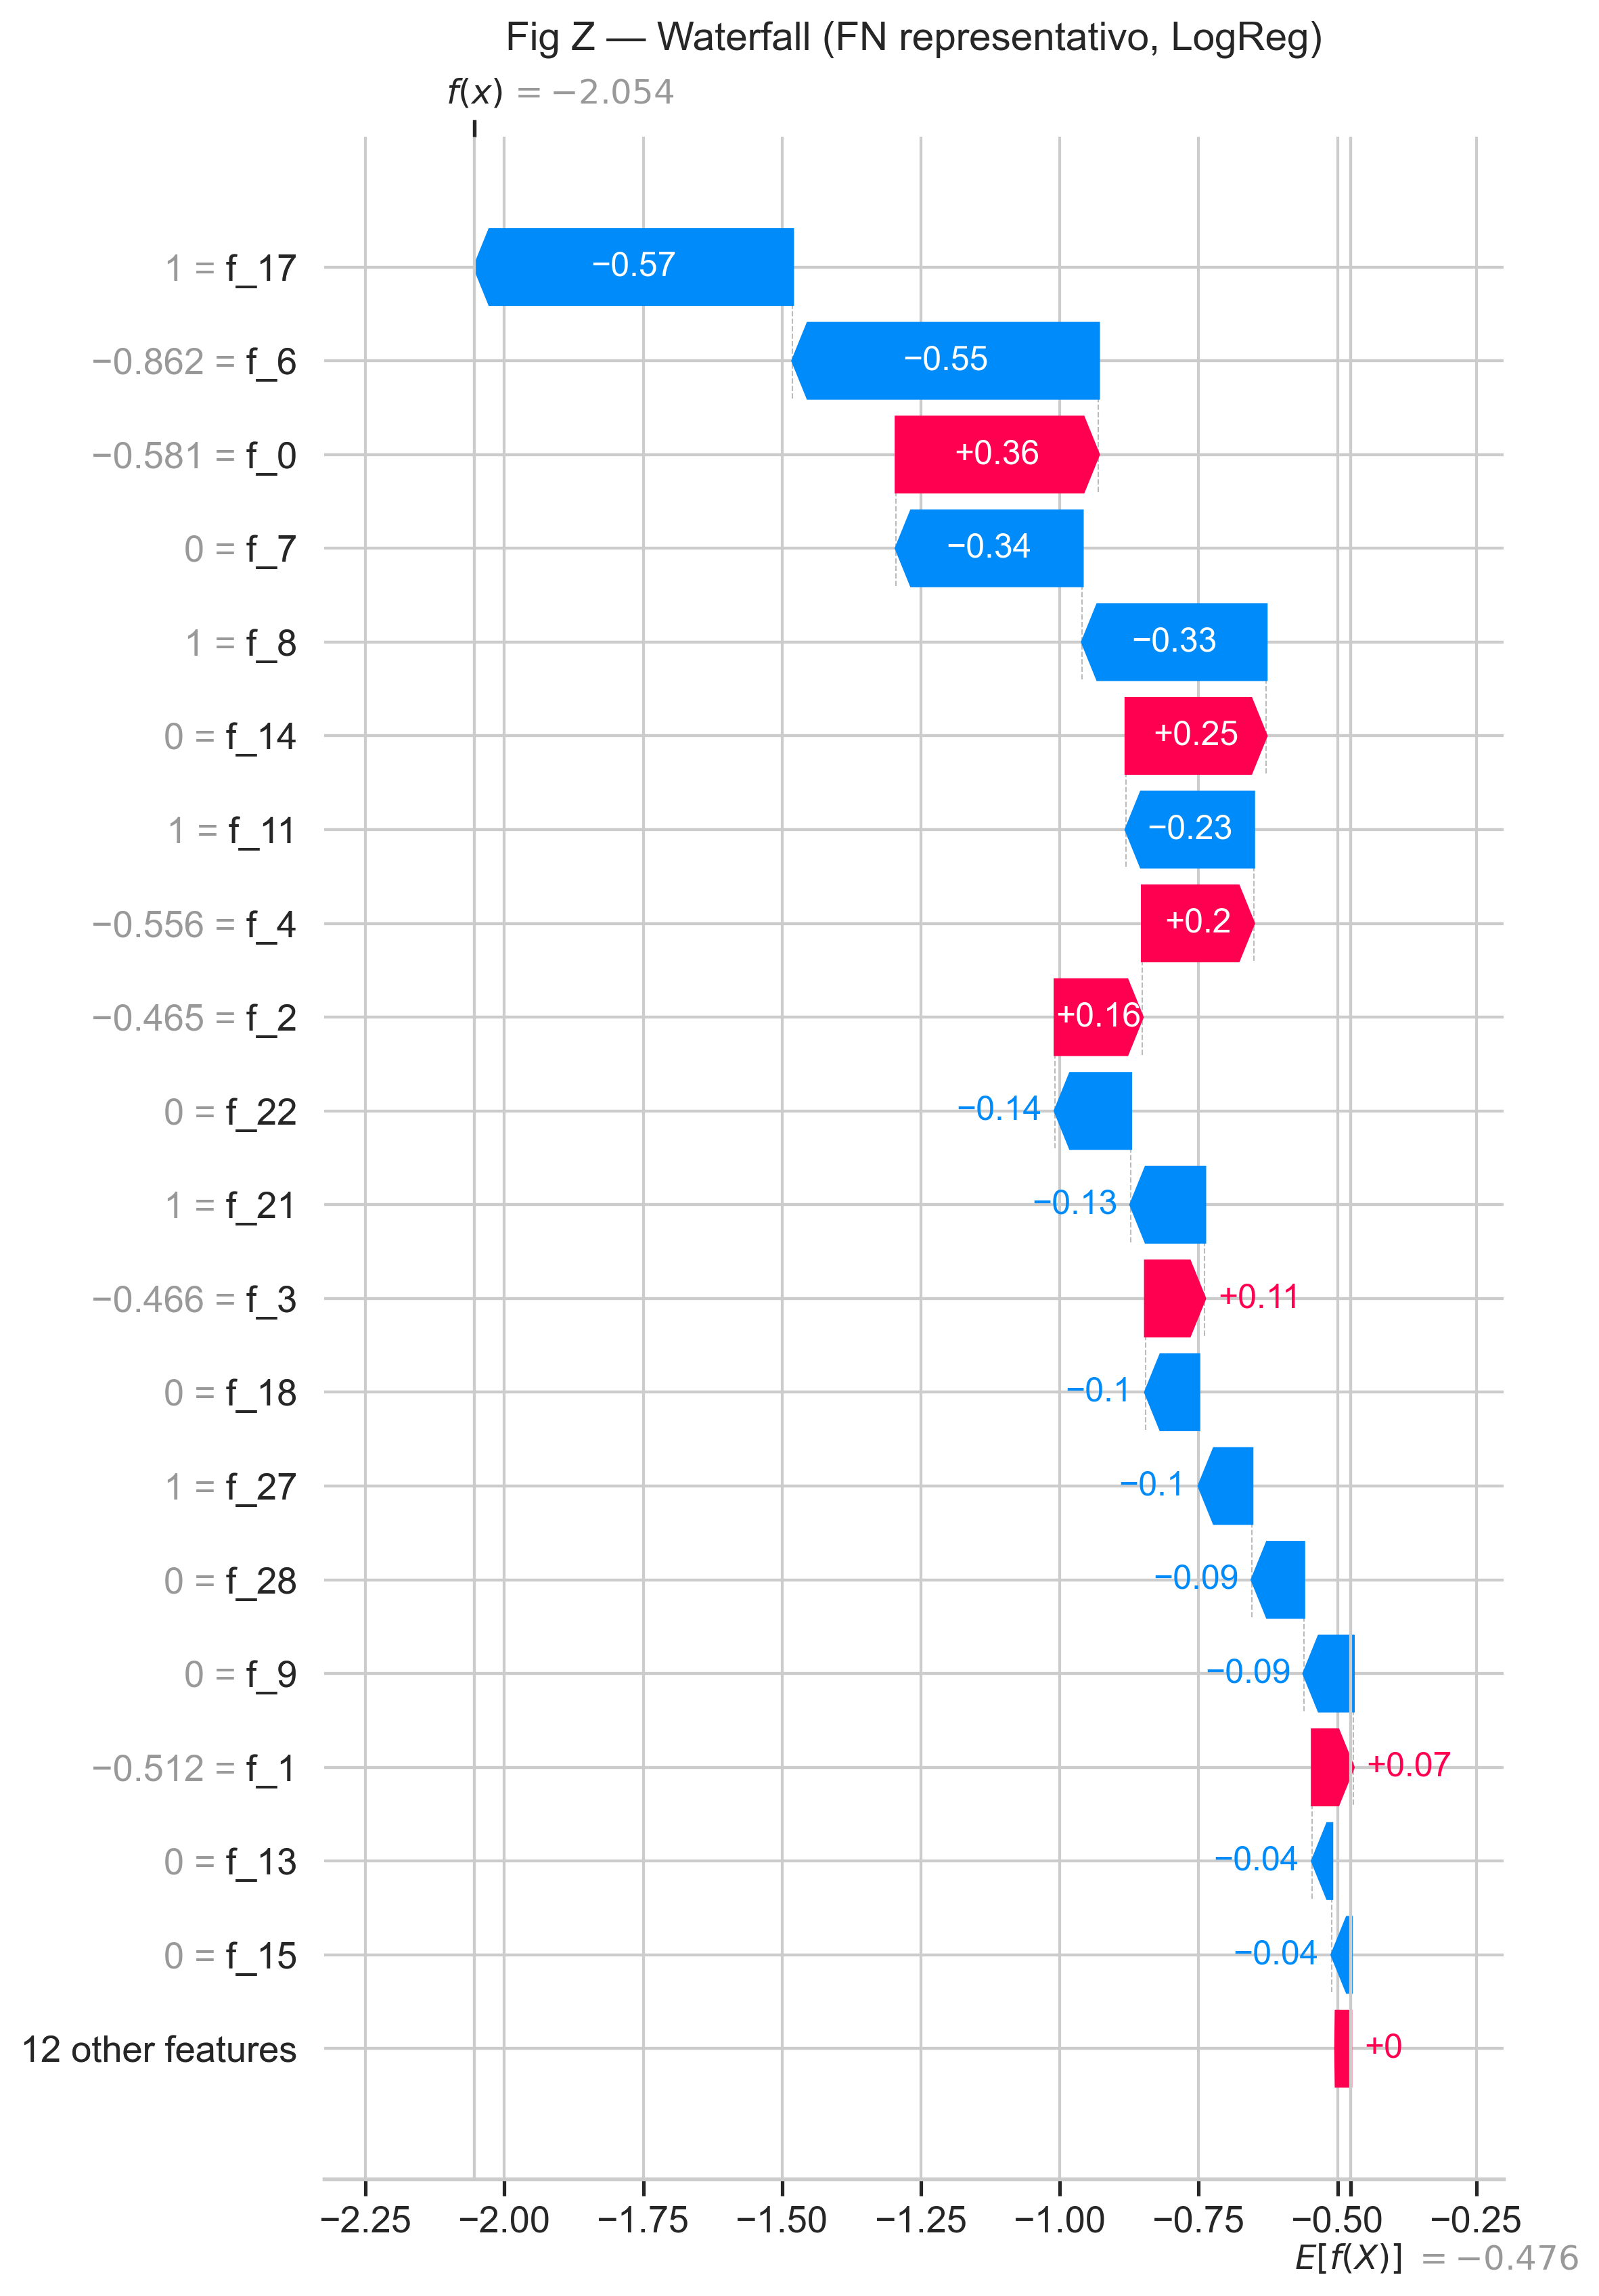

In [6]:
# Elegimos ejemplos representativos:
# 1) Verdadero positivo de alta probabilidad
proba_test_lr = logreg.predict_proba(X_test)[:, 1]
y_pred_lr = (proba_test_lr >= 0.525).astype(int)  # umbral adoptado

idx_tp = np.where((y_test == 1) & (y_pred_lr == 1))[0]
idx_fn = np.where((y_test == 1) & (y_pred_lr == 0))[0]

# Si no hay FN/TP, caemos al de mayor |shap| sum
def pick_idx_fallback(shap_values):
    sums = np.abs(shap_values.values).sum(axis=1)
    return int(np.argmax(sums))

# SHAP values fila a fila para waterfall
if len(idx_tp) == 0 or len(idx_fn) == 0:
    shap_row1 = shap_values_test[pick_idx_fallback(shap_values_test)]
    shap_row2 = shap_values_test[pick_idx_fallback(shap_values_test)]
else:
    shap_row1 = shap_values_test[int(idx_tp[0])]
    shap_row2 = shap_values_test[int(idx_fn[0])]

figz1_path = plot_shap_waterfall(
    shap_row1, name="shap_waterfall_tp",
    title="Fig Z — Waterfall (TP representativo, LogReg)",
    caption="Descomposición aditiva SHAP: cómo contribuye cada feature a desplazar la predicción hacia 'sobrevive' en un TP."
)
display(Image(filename=str(figz1_path)))

figz2_path = plot_shap_waterfall(
    shap_row2, name="shap_waterfall_fn",
    title="Fig Z — Waterfall (FN representativo, LogReg)",
    caption="Descomposición SHAP para un falso negativo: identifica señales que arrastraron la predicción hacia 'no sobrevive'."
)
display(Image(filename=str(figz2_path)))


In [7]:
from src.evaluation import feature_names_from_fitted_preproc

feat_names = feature_names_from_fitted_preproc(preproc, df_sample=X_train_df, fare_col="Fare")
print(len(feat_names), "features transformadas")
print(feat_names[:20])  # chequeo rápido

# --- Regenera mapping real ---
alias_to_real = {f"f_{i}": str(feat_names[i]) for i in range(len(feat_names))}
map_df = pd.DataFrame({"alias": [f"f_{i}" for i in range(len(feat_names))],
                       "feature_name": [str(n) for n in feat_names]})
from src.utils import p
map_path = p("results", "tables", "feature_name_mapping.csv")
map_path.parent.mkdir(parents=True, exist_ok=True)
map_df.to_csv(map_path, index=False, encoding="utf-8")
display(map_df.head(25))

31 features transformadas
['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'FarePerPerson', 'Fare_log', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer']


,alias,feature_name
0,f_0,Age
1,f_1,Fare
2,f_2,SibSp
3,f_3,Parch
4,f_4,FamilySize
5,f_5,FarePerPerson
6,f_6,Fare_log
7,f_7,Sex_female
8,f_8,Sex_male
9,f_9,Pclass_1


## Análisis de interpretabilidad 

**Features más influyentes (SHAP, LogReg).**  
El summary SHAP sitúa como más determinantes en orden aproximado por |SHAP| medio a:
- **Title_Mr**, **Title_Master**
- **Sex_female**, **Sex_male**
- **Fare_log**, **Age**
- (y, con menor peso relativo pero presentes) **FamilySize**, **Pclass_3**, **HasCabin_0/1**

Estos rasgos muestran la mayor dispersión horizontal en la figura (impacto sobre la salida). El color en el beeswarm indica la **dirección**: p. ej., valores altos de **Fare_log** suelen empujar hacia *sobrevive*, mientras que pertenecer a **Title_Mr** o **Sex_male** tiende a empujar hacia *no sobrevive*.

**Comparación entre modelos (Top-10).**  
Hay un **núcleo de señales robustas** que aparecen repetidamente en varios modelos:
- Socio-demográficas: **Sex_female**, **Sex_male**, **Title_Mr**, **Title_Master**
- Capacidad económica: **Fare_log**, **Fare**, **FarePerPerson**
- Estructura del viaje: **FamilySize**, **Pclass_3**
- Contexto de cabina/registro: **HasCabin_0**, **HasCabin_1**, **Embarked_S**

Matices por tipo de modelo:
- **LogReg** prioriza **Title_Mr**, **Title_Master**, **Sex_female/Sex_male**, **Fare_log**, **Age** (patrón lineal claro).
- **Random Forest** eleva **Age**, **FarePerPerson**, **Fare_log**, **Fare** y **FamilySize**, además de **Sex** y **Title_Mr** → sugiere **no linealidades/interacciones** en variables de dinero/familia.
- **XGBoost** destaca **Sex_male**, **Title_Mr**, **Pclass_3**, **Title_Officer**, **FamilySize**, **HasCabin_1/0** y **Embarked_S** → refuerza señales socio-económicas y de cabina.
- **SVM (perm)** resalta **SibSp**, **FamilySize**, **Fare_log**, **Title_Master**, **HasCabin_0/1** → confirma efectos no lineales en **familia** y **tarifa**.

**Casos representativos (Waterfall, LogReg).**  
- **TP**: contribuciones positivas de **Title_Mr (ausente)**/**Title_Master**, **Sex_female**, **Fare_log** y **(a veces) Pclass baja** superan a negativas como **Pclass_3**, **HasCabin_0** o ciertas combinaciones de **Age** y **FamilySize**, empujando a *sobrevive*.  
- **FN**: fuertes aportes negativos de **Title_Mr** y **Sex_male**, combinados con **Fare_log** bajo y **Pclass_3**, no son compensados por señales positivas menores (p. ej., algo de **Fare** o **FamilySize**), dejando el caso como *no sobrevive*. Estos FN marcan **regiones** donde merece la pena revisar **umbrales** o explorar **interacciones** (p. ej., *Fare × Pclass*, *FamilySize × Sex*).

**Vinculación con las hipótesis.**
- **H1 (estatus/títulos)**: la alta influencia de **Title_Mr**, **Title_Master**, **Title_Officer** valida que el **estatus social/título** correlaciona con la supervivencia.
- **H2 (familias pequeñas)**: la relevancia de **FamilySize**, **SibSp** e **IsAlone** (cuando aparece) y los modelos no lineales sugieren un **efecto curvilíneo** (mejor resultado en tamaños intermedios), consistente con la hipótesis.
- **H3 (tarifa intra-clase)**: la presencia consistente de **Fare_log/Fare/FarePerPerson** junto con **Pclass** apoya que, **dentro de la misma clase**, tarifas más altas se asocian a mayor probabilidad de sobrevivir.
